#Preamble

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


For convenience, the `plot_silhouette` function discussed in class is below.

In [2]:
import matplotlib.cm as cm
def plot_silhouette(samples,
                    labels, 
                    ax=None,
                    cmap='Dark2'):
  if (ax is None):
    ax = plt.gca()

  # sort samples by label, and add index
  df = (np
     .c_[samples, labels]
     .view(dtype=[("samples", float), ("labels", float)]))
  df.sort(axis=0, order=["labels", "samples"])
  df = np.c_[df.view(float), np.arange(df.shape[0])]

  # bar plot
  z = ax.barh(df[:,2], df[:,0], 1)

  #color map for plotting
  cmap = cm.get_cmap(cmap)

  #set bar colors
  maxcluster = np.max(df[:, 1])
  for ix, k in enumerate(df):
    z[ix].set_color(cmap(k[1]/maxcluster))

  #label y axis ticks
  yticks = []
  yticklabels = []

  bounds = np.r_[np.argwhere(np.diff(df[:,1], prepend=[0]) > 0).ravel(), 
                 df.shape[0]].ravel()
  for ix, b in enumerate(bounds):
    low = bounds[ix - 1] if ix > 0 else 0
    high = b
    yticks.append((low + high)/2)
    yticklabels.append(df[low,1].astype(labels.dtype))

  #axis decorations
  bounds, yticks, yticklabels
  ax.set_yticks(yticks)
  ax.set_yticklabels(yticklabels)
  ax.grid()
  ax.set_ylabel("Cluster")
  ax.set_xlabel("Silhouette")
  return ax

# Problem 1

In the 602 shared drive, the file /data/cluster.txt contains a features matrix $\mathbf{X}\in\mathbb{R}^{10,000\times20}$.  (You can use `np.loadtxt` to read the file as a numpy matrix.)  This features was generated from scikit-learn's `make_blobs` function with parameters of `n_features=20` and centers uniformly distributed in $[-5, 5]$ along each axis.  The dataset was produced with at least 5 but no more than 15 clusters.  Find the number of clusters used to generate the dataset (i.e., $k$ that best clusters the data), and justify your conclusion using silhouette plots.


## Preamble

Load required packages and load matrix

In [3]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt

In [6]:
X = np.loadtxt("/content/drive/Shareddrives/DS602-F22/Data/cluster.txt")

## Preprocessing

In [7]:
X = MinMaxScaler().fit_transform(X)

## Find entropy curve

The problem indicates that we have between 5 and 15.  We can run k-means estimates for $k$ between 2 and 15 (we need to test values less than 5 to observe the elbow effect if $k$ is low).  To avoid multiple fits for each $k$, we'll also save the predicted clusters and silhouette samples for later.

In [8]:
scores = {}
for k in range(2, 16):
  km = KMeans(n_clusters=k)
  y_pred = km.fit_predict(X)
  scores[k] = {"k": k,
               "inertia": km.inertia_, 
               "samples": silhouette_samples(X, y_pred),
               "pred": y_pred}

At this point, we can plot the entropy curve:

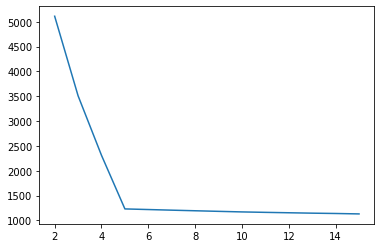

In [10]:
plt.plot(
    [x for x in scores.keys()],
    [x["inertia"] for x in scores.values()]
)

We clearly observe an elbow at $k=5$, which strongly suggests the data was produced from 5 clusters.  We can confirm with a silhouette plot for values of $k$ in the neighborhood.

## Silhouette plots

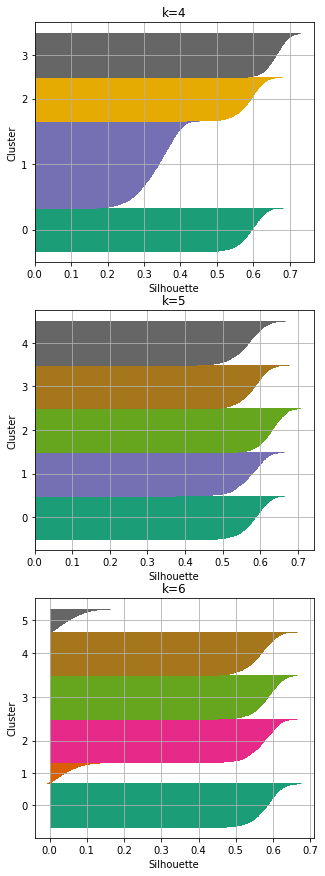

In [11]:
rangescores = [scores[x] for x in scores if 4 <= x <= 6]
fig, axs = plt.subplots(len(rangescores), 1, figsize=(5,15))
for ix, (s, ax) in enumerate(zip(rangescores, axs.ravel())):
  plot_silhouette(s['samples'], s['pred'], ax)
  ax.set_title(f"k={s['k']}")

The silhouette plot at $k=5$ indicates clusters of roughly equal size and inertia; other clusters in the neighborhood show inferior performance as evinced by unequal clusters.  This observation reinforces our hypothesis that $k=5$, which is in fact the number of clusters from which the dataset was generated.

## Appendix

The code used to generate the dataset is shown below.  The random seed results in 5 clusters being generated:

In [12]:
rng = np.random.default_rng(42)
n_clusters = rng.integers(5, 15)
centers = rng.uniform(-5, 5, (n_clusters, 20))
X, y_ = make_blobs(n_samples=10000, n_features=20, centers=centers)

print(f"n_clusters={n_clusters}")

#Do not run:
#np.savetxt("/content/drive/Shareddrives/602/Data/cluster.txt")

n_clusters=5


# Problem 2
The Fashion-MNIST dataset is a dataset of 10,000 grayscale images of size $28\times28$.  Each image depicts an article of clothing.  Load the dataset from OpenML (the dataset name is "Fashion-MNIST") and retain only the first 5,000 images.  Find an optimal number of Gaussian components based on the Akaike Information Criterion (AIC), and use the AIC scores to cluster the data using a GMM.  Visually inspect the model outcomes.  Is the clustering the model selected meaningful (e.g., are the cluster separations intuitive)?

## Preamble

We'll need to load the first 5,000 rows of the MNIST dataset and import some additional classes.  We discard the target variable in the dataset, as we want to infer the structure on unlabeled data.

In [13]:
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture

In [16]:
X, _ = fetch_openml("Fashion-MNIST", return_X_y=True, as_frame=False)
# keep only the first 5,000 images
X = X[:5000,:]

## Tune number of components

We need to find a reasonable number of Gaussian components.  We can try (somewhat arbitrarily) in the range $[3, 30]$, in steps of 2.  This will take a few minutes to run.  In practice, we could improve efficiency by sampling over steps and iteratively tuning, or training on a smaller sample.

In [17]:
aics = []
ks = []
for k in range(3, 30, 2):
  print(k, end='...')
  gmm = GaussianMixture(n_components=k)
  gmm.fit(X)
  aic = gmm.aic(X)
  aics.append(aic)
  print(f"...AIC={aic}")
  ks.append(k)

3......AIC=27872122.90356814
5......AIC=23167044.907398608
7......AIC=17061577.72146637
9......AIC=10850105.887231568
11......AIC=7081572.368434792
13......AIC=2660612.494396463
15......AIC=-86653.47223475948
17......AIC=-2519501.952293996
19......AIC=-5290626.674060941
21......AIC=-6221232.585698314
23......AIC=-5534567.385537989
25......AIC=-7278384.267691508
27......AIC=-7821318.012752339
29......AIC=-7543477.068181209


We can now plot the AIC curve:

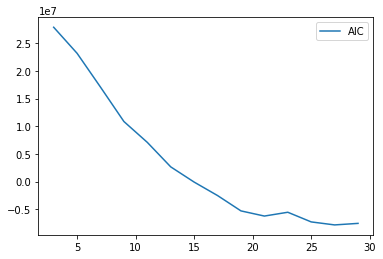

In [18]:
plt.plot(ks, aics, label='AIC')
plt.legend()

We observe an elbow at ~20 components, which we can proceed to use.  Since we will be using this as our final model, we will set `n_init` to 10.  This will run the fit 10 times and select the best iteration.  Because like K-Means, the EM algorithm can converge to a suboptimal solution, multiple iterations decrease the likelihood of arriving at a suboptimal solution.  Of course, this approach will also increase the time required to fit.  

In [19]:
gmm = GaussianMixture(n_components=20, n_init=10, verbose=3, verbose_interval=1)

We can now fit the model and predict labels.  This will require 10-20 minutes to run.

In [20]:
labels = gmm.fit_predict(X)

Initialization 0
  Iteration 1	 time lapse 18.24536s	 ll change inf
  Iteration 2	 time lapse 10.02018s	 ll change 0.00000
Initialization converged: True	 time lapse 28.26575s	 ll 1809.60912
Initialization 1
  Iteration 1	 time lapse 15.98617s	 ll change inf
  Iteration 2	 time lapse 10.07520s	 ll change 3.02118
  Iteration 3	 time lapse 12.35391s	 ll change 0.78993
  Iteration 4	 time lapse 10.02582s	 ll change 0.00000
Initialization converged: True	 time lapse 48.44215s	 ll 1605.79222
Initialization 2
  Iteration 1	 time lapse 16.15520s	 ll change inf
  Iteration 2	 time lapse 11.26879s	 ll change 0.00000
Initialization converged: True	 time lapse 27.42997s	 ll 1912.47432
Initialization 3
  Iteration 1	 time lapse 18.99173s	 ll change inf
  Iteration 2	 time lapse 12.31470s	 ll change 0.00000
Initialization converged: True	 time lapse 31.30741s	 ll 1784.66442
Initialization 4
  Iteration 1	 time lapse 15.96935s	 ll change inf
  Iteration 2	 time lapse 10.04583s	 ll change 0.00000
Ini

## Evaluation

We can visually evaluate a general goodness of fit by displaying observations from each cluster.  Each row represents a cluster, and each column a sample from the cluster.

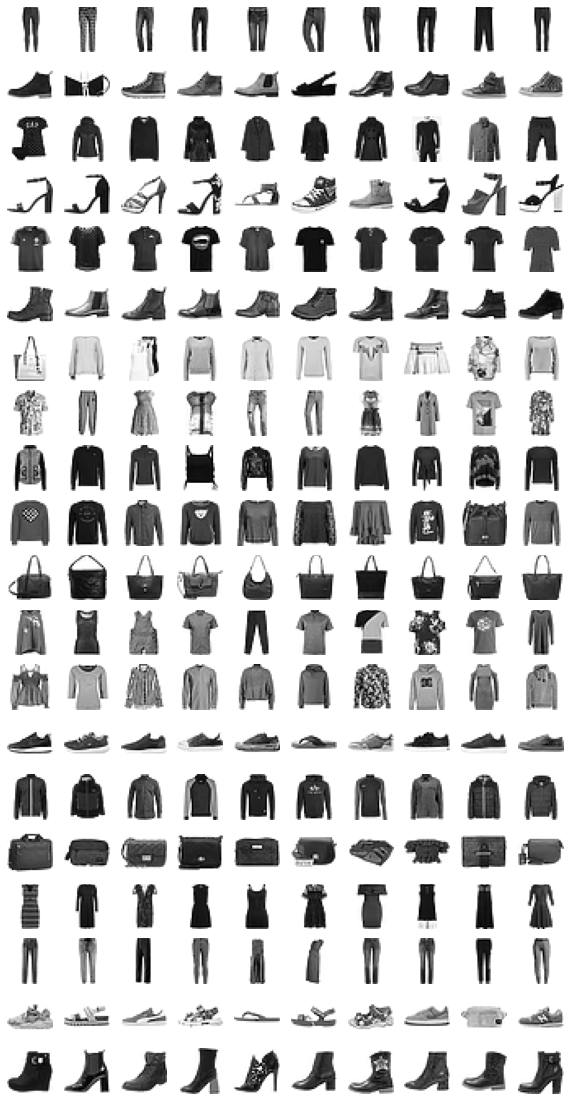

In [21]:
clusters = np.unique(labels)
fig, axs = plt.subplots(len(clusters),10, figsize=(10,len(clusters)))
for cix, c in enumerate(clusters):
  candidx = np.argwhere(labels==c).ravel()
  sampidx = np.random.choice(candidx, 10, replace=False)
  for six, s in enumerate(sampidx):
    ax = axs[cix,six]
    img = X[s].reshape(28,28)
    ax.imshow(img, cmap='gray_r')
    ax.set_axis_off()
  

Qualitatively, the results evince good clustering.  In general, similar articles of clothing are being assigned to the same cluster.  The clustering incorporates hue (i.e., light- and dark-shaded articles of the same article of clothing may be assigned to different clusters), whereas the original classification does not consider hue.

# Problem 3
Import the MNIST-784 dataset (handwritten numbers), and keep only observations labeled as `7'.   Using an outlier detection method of your choice, identify outlier observations, i.e., observations that do not resemble other observations in the dataset.  Display a sample of 5-10 detected outlier observations.

## Preamble

We'll use local outlier factors (LOF) to find outlying points.

In [22]:
from sklearn.datasets import fetch_openml
from sklearn.neighbors import LocalOutlierFactor
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [24]:
X, y = fetch_openml('mnist_784', return_X_y=True, as_frame=False)
X = X[y=='7', :]

## Finding local outlier factors

In [25]:
lof = LocalOutlierFactor(10)
lof.fit(X)
nof = lof.negative_outlier_factor_

## Analysis
We examine the distribution of the outlier score, which shows high skew and a small number of extreme outliers.  We also observe an elbow at about -1.25, which can serve as a natural inflection point to separate outlier points.  We can also check the first percentile is roughly at this inflection point.

-1.4052148535600348

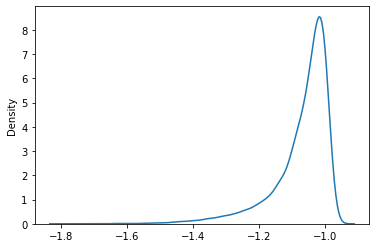

In [26]:
sns.kdeplot(nof)
np.percentile(nof, 1)

We can now store the indices of outliers, ordered by the negative outlier factor, for evaluation.

In [27]:
outlier_idx = np.argwhere(nof < np.percentile(nof, 1)).ravel()
outlier_idx_order = np.argsort(nof[outlier_idx])
outlier_idx = outlier_idx[outlier_idx_order]

## Evaluation

To evaluate effectiveness at showing outliers, we can show samples of:

* A sample of extreme outliers (10 samples from 1st percentile)
* The most extreme outliers (10 lowest negative outlier factor)
* Normal points for comparison (10 samples from 25th percentile and above)

In [28]:
def plot_10_samples(idx):
  fig, axs = plt.subplots(2,5, figsize=(8,4))
  for idx, ax in zip(idx, axs.ravel()):
    cnof = nof[idx]
    ax.imshow(X[idx].reshape(28,28), cmap='gray_r')
    ax.set_axis_off()
    ax.set_title(f"{idx}: LOF={cnof:.2f}")
  fig.tight_layout()

### Outlier Sample

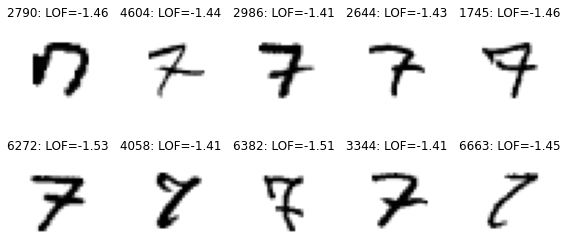

In [29]:
plot_10_samples(np.random.choice(outlier_idx, 10, replace=False))

### Extreme Outliers

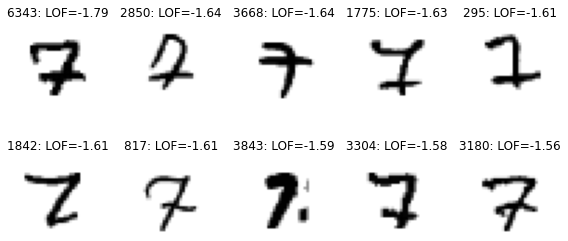

In [30]:
  plot_10_samples(outlier_idx[:10])

### Typical samples

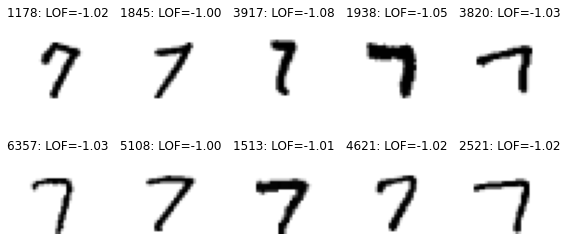

In [31]:
inlier_idx = np.argwhere(nof > np.percentile(nof, 25)).ravel()
plot_10_samples(np.random.choice(inlier_idx, 10, replace=False))

### Conclusion
Visual inspection shows that the outlying observations are outliers in the sense that they are characterized by unusual visual features such as display artifacts, inconsistent or unusual line thickness, or unusual glyphs.  This visual difference provides evidence that the LOF approach is effective in identifying outlier samples.